# Deep Residual Learning for Image Recognition: CIFAR-10 

This notebook provides a PyTorch implementation of *Deep Residual Learning for Image Recogniton* by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Han Sun which achived state of the art in 2015 by winning the ILSVRC and COCO challenges.

In [8]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

from resnet import ResNet
from data_loader import get_data_loaders, plot_images
from utils import calculate_normalisation_params
from train import train


import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_data_loaders(data_dir,
                     batch_size,
                     train_transform,
                     test_transform,
                     shuffle=True,
                     num_workers=4,
                     pin_memory=False):
    
    # Load the datasets
    train_dataset = datasets.CIFAR100(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    test_dataset = datasets.CIFAR100(
        root=data_dir, train=False,
        download=True, transform=test_transform,
    )
    
    # Create loader objects
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory
    )
          
    return (train_loader, test_loader)


def plot_images(images, cls_true, cls_pred=None):
    """
    Plot images with labels.
    """
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [4]:
# GLOBALS
# -----------------------

data_dir = 'data/cifar100'
batch_size = 128


## Data augmentation: Training set

Files already downloaded and verified
Files already downloaded and verified


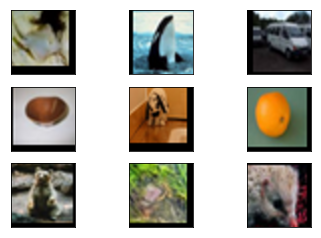

torch.Size([128, 3, 32, 32])


In [5]:
# VISUALISE
# -----------------------

# Load data without normalisations

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor()
])

train_loader, test_loader = get_data_loaders(data_dir,
                                             batch_size,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True
                            )


# Training images
data_iter = iter(train_loader)
images, labels = data_iter.next()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

The training set consists of 50,000 32x32 pixel images. These are padded with 4 pixels on each side, before a crop is randomly sampled from the padded image or its horziontal flip. 

The authors cite C.-Y. Lee, S. Xie, P. Gallagher, Z. Zhang, and Z. Tu. Deeply-supervised nets. arXiv:1409.5185, 2014. This paper suggests that 'corner cropping' should be used which could be interpretted one of two ways:

1. There are five possible crops for each image, centre and then four further crops with the crop placed tightly in each corner. This equates to `torchvision.transforms.FiveCrop()` in PyTorch.
2. The crop position is randomly selected from any possible position within the bounds of the padded image. Equivalent to `torchvision.transforms.RandomCrop()` in PyTorch.

The intended implementation seem ambiguous to me, so I implemented the latter here largely for simplicity.

## Data augmentation: Test set

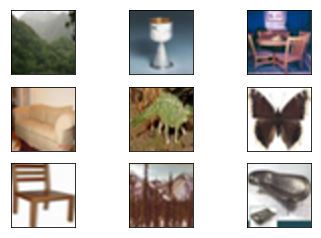

torch.Size([128, 3, 32, 32])


In [6]:
# Test images
data_iter = iter(test_loader)
images, labels = data_iter.next()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

There are 10,000 images in the test set. These are not transformed.

## Calculate normalisation parameters

The authors don't explicitly state if the images are normalised prior to training, however the paper referenced on preprocessing (C.-Y. Lee, S. Xie, P. Gallagher, Z. Zhang, and Z. Tu. Deeply-supervised nets. arXiv:1409.5185, 2014) notes that normalisation is used. 

I was unsure if the mean and standard deviation of the dataset should be calculated before or after augmentation for this purpose. It is also unclear if these calcualations should be done across the training and test set combined, or only the training set.

Her I've used the pre-transform training and test set combined.

In [9]:
# NORMALIZATION
# -----------------------
# Calculate the mean and standard deviation of each channel
# for all observations in training and test datasets. The
# results can then be used for normalisation

# Load data without transforms
if False:
    train_transform = transforms.Compose([
        # 4 pixels are padded on each side, 
        transforms.ToTensor()
    ])

    test_transform = transforms.Compose([
        # For testing, we only evaluate the single 
        # view of the original 32×32 image.
        transforms.ToTensor()
    ])

    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)


    # Takes a while to run so I've hardcoded results below
    means, stds = calculate_normalisation_params(train_loader, test_loader)
    print(f'means: {means}')
    print(f'stds: {stds}')

## Preprocessing

Here we finalise data augmentation and normalisation parameters ahead of training.

In [7]:
# SET FINAL TRANSFORMS WITH NORMALISATION

# [x] simple data augmentation in [24]
# [x] 4 pixels are padded on each side, 
# [x] and a 32×32 crop is randomly sampled from the padded image or its horizontal flip.
# [x] For testing, we only evaluate the single view of the original 32×32 image.


# Normalisation parameters fo CIFAR10
means = [0.5073620454508597, 0.5073476735815876, 0.5073388932431507]
stds = [0.2674881567914382, 0.26748295476409184, 0.26749118723194065]

normalize = transforms.Normalize(
    mean=means,
    std=stds,
)

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor(),
    normalize
])

Notes:

- Note: downsampling with stride 2 results in uneven convolution, e.g. W_out is 16.5. Why didn't the authors use Maxpooling, would have been neater.

## Training

The authors report their results in term of training iterations. I've assumed an iteration here means a forwards and backwards pass of a batch of 128 observations through the entire network.

It seems more convenient to work in epochs in PyTorch, so here I calculate the integer number of iterations per epoch for later conversions. The results is 391 iterations per epoch. An epoch is a forwards and backwards pass for all observations in the training set.

In [8]:
# How many iterations in an epoch?
iterations = 0
for i, data in enumerate(train_loader, 0):
    iterations +=1
print(iterations)

391


### Hyperparameters

Set the hyperparameters as described by the authors, with iterations converted to epochs where appropriate.

In [9]:
# TRAINING PARAMETERS
# -------------------------

# Authors cite 64k iterations
# 64000/391 = 164
epochs = 164

# OPTIMISER PARAMETERS
lr = 0.1 # authors cite 0.1
momentum = 0.9
weight_decay = 0.0001 

# LEARNING RATE ADJUSTMENT
# Reduce learning rate at iterations 
# 32k and 48k. Convert to epochs:
# e.g. iterations / (n_observations/batch_size) 
# 32000/391 = 82
# 48000/391 = 123
milestones = [82, 123]
# Divide learning rate by 10 at each milestone
gamma = 0.1

### Plain nets

Run training loop for **'plain' convolutional networks** without shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers. 

In [11]:
# TRAIN PLAIN NETs
%%time
# n determines network size as described in paper
# where total number of layers is (6*n)+2
# ns = [3, 5, 7, 9]
ns = [3, 5, 7, 9, 18]
# Train plainnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)
    
    model = ResNet(n, shortcuts=False, num_cls=100)
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'results/plainnet{6*n+2}_100.csv'
    model_file = f'pretrained/plainnet{6*n+2}_100.pt'
    train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

MODEL SIZE: n=3
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Epoch 	Batch 	NLLLoss_Train
1 	50 	4.571
1 	100 	4.365
1 	150 	4.213
1 	200 	4.107
1 	250 	4.114
1 	300 	4.016
1 	350 	3.959
train_err: 0.92794 test_err: 0.9197
2 	50 	3.836
2 	100 	3.842
2 	150 	3.780
2 	200 	3.732
2 	250 	3.671
2 	300 	3.648
2 	350 	3.578
train_err: 0.86332 test_err: 0.8623
3 	50 	3.544
3 	100 	3.489
3 	150 	3.466
3 	200 	3.444
3 	250 	3.400
3 	300 	3.400
3 	350 	3.348
train_err: 0.82692 test_err: 0.8196
4 	50 	3.265
4 	100 	3.283
4 	150 	3.185
4 	200 	3.222
4 	250 	3.174
4 	300 	3.145
4 	350 	3.115
train_err: 0.77886 test_err: 0.7806
5 	50 	3.006
5 	100 	2.986
5 	150 	2.972
5 	200 	2.972
5 	250 	2.924
5 	300 	2.910
5 	350 	2.885
train_err: 0.7832 test_err: 0.7812
6 	50 	2.795
6 	100 	2.779
6 	150 	2.742
6 	200 	2.760
6 	250 	2.736
6 	300 	2.710
6 	350 	2.701
train_err: 0.72346 test_err: 0.7311
7 	50 	2.618
7 	100 	2.607
7 	150 	2.585
7 	200 	2.571
7 	250 	2.585
7 	300 

59 	200 	1.277
59 	250 	1.307
59 	300 	1.289
59 	350 	1.304
train_err: 0.38552 test_err: 0.4559
60 	50 	1.227
60 	100 	1.264
60 	150 	1.310
60 	200 	1.271
60 	250 	1.264
60 	300 	1.305
60 	350 	1.290
train_err: 0.42706 test_err: 0.4799
61 	50 	1.177
61 	100 	1.243
61 	150 	1.249
61 	200 	1.284
61 	250 	1.298
61 	300 	1.287
61 	350 	1.290
train_err: 0.39058 test_err: 0.4601
62 	50 	1.216
62 	100 	1.193
62 	150 	1.262
62 	200 	1.269
62 	250 	1.277
62 	300 	1.306
62 	350 	1.273
train_err: 0.48828 test_err: 0.5385
63 	50 	1.192
63 	100 	1.272
63 	150 	1.219
63 	200 	1.246
63 	250 	1.307
63 	300 	1.285
63 	350 	1.304
train_err: 0.39044 test_err: 0.4599
64 	50 	1.233
64 	100 	1.224
64 	150 	1.245
64 	200 	1.265
64 	250 	1.301
64 	300 	1.290
64 	350 	1.283
train_err: 0.43156 test_err: 0.4939
65 	50 	1.177
65 	100 	1.234
65 	150 	1.218
65 	200 	1.273
65 	250 	1.275
65 	300 	1.295
65 	350 	1.293
train_err: 0.4009 test_err: 0.4663
66 	50 	1.211
66 	100 	1.218
66 	150 	1.278
66 	200 	1.284
66 	25

117 	100 	0.657
117 	150 	0.660
117 	200 	0.607
117 	250 	0.625
117 	300 	0.646
117 	350 	0.683
train_err: 0.18256 test_err: 0.3584
118 	50 	0.655
118 	100 	0.629
118 	150 	0.606
118 	200 	0.660
118 	250 	0.658
118 	300 	0.650
118 	350 	0.654
train_err: 0.18302 test_err: 0.3595
119 	50 	0.615
119 	100 	0.634
119 	150 	0.627
119 	200 	0.650
119 	250 	0.629
119 	300 	0.667
119 	350 	0.650
train_err: 0.18292 test_err: 0.3607
120 	50 	0.623
120 	100 	0.637
120 	150 	0.620
120 	200 	0.635
120 	250 	0.648
120 	300 	0.635
120 	350 	0.644
train_err: 0.18146 test_err: 0.3665
121 	50 	0.619
121 	100 	0.644
121 	150 	0.616
121 	200 	0.633
121 	250 	0.667
121 	300 	0.652
121 	350 	0.637
train_err: 0.17694 test_err: 0.3619
122 	50 	0.631
122 	100 	0.618
122 	150 	0.614
122 	200 	0.623
122 	250 	0.632
122 	300 	0.657
122 	350 	0.643
train_err: 0.1815 test_err: 0.3642
123 	50 	0.628
123 	100 	0.636
123 	150 	0.623
123 	200 	0.625
123 	250 	0.632
123 	300 	0.630
123 	350 	0.643
train_err: 0.17946 test

train_err: 0.76996 test_err: 0.7647
9 	50 	2.836
9 	100 	2.888
9 	150 	2.855
9 	200 	2.878
9 	250 	2.851
9 	300 	2.863
9 	350 	2.811
train_err: 0.73166 test_err: 0.7277
10 	50 	2.740
10 	100 	2.766
10 	150 	2.804
10 	200 	2.764
10 	250 	2.724
10 	300 	2.732
10 	350 	2.745
train_err: 0.7141 test_err: 0.7028
11 	50 	2.650
11 	100 	2.646
11 	150 	2.685
11 	200 	2.641
11 	250 	2.633
11 	300 	2.649
11 	350 	2.582
train_err: 0.71234 test_err: 0.7135
12 	50 	2.558
12 	100 	2.558
12 	150 	2.536
12 	200 	2.556
12 	250 	2.575
12 	300 	2.567
12 	350 	2.585
train_err: 0.69478 test_err: 0.7059
13 	50 	2.473
13 	100 	2.514
13 	150 	2.481
13 	200 	2.489
13 	250 	2.457
13 	300 	2.476
13 	350 	2.512
train_err: 0.67484 test_err: 0.6721
14 	50 	2.405
14 	100 	2.430
14 	150 	2.434
14 	200 	2.420
14 	250 	2.415
14 	300 	2.405
14 	350 	2.472
train_err: 0.64976 test_err: 0.6507
15 	50 	2.344
15 	100 	2.358
15 	150 	2.384
15 	200 	2.384
15 	250 	2.390
15 	300 	2.408
15 	350 	2.331
train_err: 0.68732 test_err:

67 	250 	1.481
67 	300 	1.518
67 	350 	1.503
train_err: 0.4407 test_err: 0.5055
68 	50 	1.422
68 	100 	1.464
68 	150 	1.453
68 	200 	1.481
68 	250 	1.566
68 	300 	1.532
68 	350 	1.528
train_err: 0.4764 test_err: 0.5312
69 	50 	1.422
69 	100 	1.481
69 	150 	1.497
69 	200 	1.460
69 	250 	1.526
69 	300 	1.559
69 	350 	1.505
train_err: 0.50202 test_err: 0.5472
70 	50 	1.431
70 	100 	1.446
70 	150 	1.485
70 	200 	1.444
70 	250 	1.498
70 	300 	1.435
70 	350 	1.490
train_err: 0.49896 test_err: 0.5406
71 	50 	1.430
71 	100 	1.428
71 	150 	1.483
71 	200 	1.461
71 	250 	1.445
71 	300 	1.526
71 	350 	1.461
train_err: 0.44956 test_err: 0.5107
72 	50 	1.435
72 	100 	1.446
72 	150 	1.488
72 	200 	1.463
72 	250 	1.435
72 	300 	1.489
72 	350 	1.466
train_err: 0.44914 test_err: 0.5046
73 	50 	1.443
73 	100 	1.439
73 	150 	1.457
73 	200 	1.501
73 	250 	1.465
73 	300 	1.448
73 	350 	1.492
train_err: 0.51486 test_err: 0.5574
74 	50 	1.399
74 	100 	1.414
74 	150 	1.433
74 	200 	1.456
74 	250 	1.503
74 	300

125 	50 	0.624
125 	100 	0.632
125 	150 	0.613
125 	200 	0.657
125 	250 	0.622
125 	300 	0.636
125 	350 	0.626
train_err: 0.17704 test_err: 0.3875
126 	50 	0.642
126 	100 	0.616
126 	150 	0.621
126 	200 	0.626
126 	250 	0.626
126 	300 	0.612
126 	350 	0.638
train_err: 0.17302 test_err: 0.3886
127 	50 	0.651
127 	100 	0.621
127 	150 	0.621
127 	200 	0.620
127 	250 	0.634
127 	300 	0.633
127 	350 	0.606
train_err: 0.17328 test_err: 0.3878
128 	50 	0.630
128 	100 	0.610
128 	150 	0.614
128 	200 	0.631
128 	250 	0.604
128 	300 	0.642
128 	350 	0.623
train_err: 0.1721 test_err: 0.3859
129 	50 	0.597
129 	100 	0.603
129 	150 	0.627
129 	200 	0.620
129 	250 	0.618
129 	300 	0.635
129 	350 	0.627
train_err: 0.1721 test_err: 0.3889
130 	50 	0.624
130 	100 	0.625
130 	150 	0.609
130 	200 	0.609
130 	250 	0.625
130 	300 	0.595
130 	350 	0.619
train_err: 0.1716 test_err: 0.3871
131 	50 	0.605
131 	100 	0.617
131 	150 	0.596
131 	200 	0.615
131 	250 	0.638
131 	300 	0.588
131 	350 	0.617
train_err:

17 	150 	2.658
17 	200 	2.638
17 	250 	2.666
17 	300 	2.651
17 	350 	2.650
train_err: 0.71156 test_err: 0.719
18 	50 	2.564
18 	100 	2.597
18 	150 	2.606
18 	200 	2.606
18 	250 	2.550
18 	300 	2.596
18 	350 	2.606
train_err: 0.71874 test_err: 0.7203
19 	50 	2.549
19 	100 	2.576
19 	150 	2.545
19 	200 	2.571
19 	250 	2.533
19 	300 	2.521
19 	350 	2.532
train_err: 0.69922 test_err: 0.7072
20 	50 	2.483
20 	100 	2.478
20 	150 	2.536
20 	200 	2.480
20 	250 	2.529
20 	300 	2.471
20 	350 	2.510
train_err: 0.68654 test_err: 0.6861
21 	50 	2.440
21 	100 	2.377
21 	150 	2.445
21 	200 	2.463
21 	250 	2.470
21 	300 	2.471
21 	350 	2.455
train_err: 0.69574 test_err: 0.6967
22 	50 	2.383
22 	100 	2.430
22 	150 	2.401
22 	200 	2.416
22 	250 	2.427
22 	300 	2.412
22 	350 	2.380
train_err: 0.6716 test_err: 0.6703
23 	50 	2.370
23 	100 	2.399
23 	150 	2.350
23 	200 	2.385
23 	250 	2.365
23 	300 	2.346
23 	350 	2.367
train_err: 0.6623 test_err: 0.6658
24 	50 	2.320
24 	100 	2.343
24 	150 	2.343
24 	200 

76 	50 	1.654
76 	100 	1.581
76 	150 	1.650
76 	200 	1.610
76 	250 	1.603
76 	300 	1.618
76 	350 	1.665
train_err: 0.48798 test_err: 0.532
77 	50 	1.572
77 	100 	1.608
77 	150 	1.572
77 	200 	1.633
77 	250 	1.638
77 	300 	1.678
77 	350 	1.633
train_err: 0.52226 test_err: 0.5637
78 	50 	1.541
78 	100 	1.563
78 	150 	1.628
78 	200 	1.605
78 	250 	1.627
78 	300 	1.668
78 	350 	1.662
train_err: 0.53428 test_err: 0.5622
79 	50 	1.573
79 	100 	1.613
79 	150 	1.565
79 	200 	1.587
79 	250 	1.662
79 	300 	1.621
79 	350 	1.656
train_err: 0.47682 test_err: 0.5245
80 	50 	1.549
80 	100 	1.599
80 	150 	1.591
80 	200 	1.648
80 	250 	1.636
80 	300 	1.627
80 	350 	1.616
train_err: 0.53392 test_err: 0.5676
81 	50 	1.594
81 	100 	1.574
81 	150 	1.613
81 	200 	1.570
81 	250 	1.603
81 	300 	1.638
81 	350 	1.585
train_err: 0.63986 test_err: 0.6643
82 	50 	1.602
82 	100 	1.574
82 	150 	1.627
82 	200 	1.626
82 	250 	1.603
82 	300 	1.643
82 	350 	1.581
train_err: 0.52462 test_err: 0.5639
83 	50 	1.426
83 	100

133 	50 	0.686
133 	100 	0.636
133 	150 	0.693
133 	200 	0.670
133 	250 	0.691
133 	300 	0.707
133 	350 	0.701
train_err: 0.18906 test_err: 0.3951
134 	50 	0.679
134 	100 	0.707
134 	150 	0.658
134 	200 	0.665
134 	250 	0.698
134 	300 	0.690
134 	350 	0.683
train_err: 0.18816 test_err: 0.3955
135 	50 	0.673
135 	100 	0.691
135 	150 	0.657
135 	200 	0.682
135 	250 	0.682
135 	300 	0.688
135 	350 	0.681
train_err: 0.18666 test_err: 0.3961
136 	50 	0.680
136 	100 	0.668
136 	150 	0.668
136 	200 	0.655
136 	250 	0.672
136 	300 	0.673
136 	350 	0.687
train_err: 0.18574 test_err: 0.3973
137 	50 	0.642
137 	100 	0.688
137 	150 	0.669
137 	200 	0.683
137 	250 	0.676
137 	300 	0.680
137 	350 	0.688
train_err: 0.18542 test_err: 0.394
138 	50 	0.639
138 	100 	0.682
138 	150 	0.682
138 	200 	0.667
138 	250 	0.663
138 	300 	0.680
138 	350 	0.659
train_err: 0.18504 test_err: 0.3937
139 	50 	0.662
139 	100 	0.665
139 	150 	0.671
139 	200 	0.680
139 	250 	0.684
139 	300 	0.670
139 	350 	0.669
train_er

25 	300 	2.920
25 	350 	2.934
train_err: 0.74994 test_err: 0.7474
26 	50 	2.908
26 	100 	2.891
26 	150 	2.915
26 	200 	2.835
26 	250 	2.867
26 	300 	2.896
26 	350 	2.888
train_err: 0.77016 test_err: 0.7732
27 	50 	2.848
27 	100 	2.861
27 	150 	2.868
27 	200 	2.865
27 	250 	2.841
27 	300 	2.847
27 	350 	2.839
train_err: 0.80238 test_err: 0.7979
28 	50 	2.798
28 	100 	2.808
28 	150 	2.813
28 	200 	2.826
28 	250 	2.805
28 	300 	2.779
28 	350 	2.796
train_err: 0.74272 test_err: 0.7427
29 	50 	2.784
29 	100 	2.790
29 	150 	2.805
29 	200 	2.779
29 	250 	2.778
29 	300 	2.723
29 	350 	2.743
train_err: 0.73872 test_err: 0.7367
30 	50 	2.723
30 	100 	2.756
30 	150 	2.720
30 	200 	2.720
30 	250 	2.763
30 	300 	2.745
30 	350 	2.704
train_err: 0.7224 test_err: 0.7274
31 	50 	2.672
31 	100 	2.710
31 	150 	2.759
31 	200 	2.733
31 	250 	2.675
31 	300 	2.689
31 	350 	2.692
train_err: 0.7261 test_err: 0.7275
32 	50 	2.637
32 	100 	2.658
32 	150 	2.699
32 	200 	2.660
32 	250 	2.685
32 	300 	2.651
32 	350

84 	150 	1.598
84 	200 	1.589
84 	250 	1.585
84 	300 	1.616
84 	350 	1.549
train_err: 0.42776 test_err: 0.4891
85 	50 	1.549
85 	100 	1.537
85 	150 	1.533
85 	200 	1.565
85 	250 	1.532
85 	300 	1.525
85 	350 	1.541
train_err: 0.41058 test_err: 0.4792
86 	50 	1.528
86 	100 	1.517
86 	150 	1.497
86 	200 	1.504
86 	250 	1.532
86 	300 	1.507
86 	350 	1.525
train_err: 0.41806 test_err: 0.4857
87 	50 	1.472
87 	100 	1.504
87 	150 	1.517
87 	200 	1.525
87 	250 	1.488
87 	300 	1.467
87 	350 	1.502
train_err: 0.40862 test_err: 0.4785
88 	50 	1.474
88 	100 	1.485
88 	150 	1.494
88 	200 	1.478
88 	250 	1.477
88 	300 	1.472
88 	350 	1.486
train_err: 0.40254 test_err: 0.4752
89 	50 	1.429
89 	100 	1.440
89 	150 	1.461
89 	200 	1.454
89 	250 	1.507
89 	300 	1.508
89 	350 	1.493
train_err: 0.39494 test_err: 0.471
90 	50 	1.459
90 	100 	1.456
90 	150 	1.497
90 	200 	1.469
90 	250 	1.459
90 	300 	1.413
90 	350 	1.459
train_err: 0.39448 test_err: 0.475
91 	50 	1.427
91 	100 	1.461
91 	150 	1.473
91 	200

141 	50 	1.089
141 	100 	1.098
141 	150 	1.104
141 	200 	1.084
141 	250 	1.113
141 	300 	1.106
141 	350 	1.117
train_err: 0.30226 test_err: 0.4501
142 	50 	1.081
142 	100 	1.100
142 	150 	1.117
142 	200 	1.092
142 	250 	1.090
142 	300 	1.084
142 	350 	1.112
train_err: 0.30164 test_err: 0.4478
143 	50 	1.113
143 	100 	1.094
143 	150 	1.069
143 	200 	1.126
143 	250 	1.106
143 	300 	1.068
143 	350 	1.062
train_err: 0.30062 test_err: 0.4518
144 	50 	1.048
144 	100 	1.096
144 	150 	1.102
144 	200 	1.099
144 	250 	1.085
144 	300 	1.108
144 	350 	1.109
train_err: 0.30102 test_err: 0.4496
145 	50 	1.075
145 	100 	1.080
145 	150 	1.095
145 	200 	1.113
145 	250 	1.101
145 	300 	1.082
145 	350 	1.092
train_err: 0.30218 test_err: 0.4488
146 	50 	1.093
146 	100 	1.066
146 	150 	1.104
146 	200 	1.108
146 	250 	1.100
146 	300 	1.095
146 	350 	1.071
train_err: 0.29818 test_err: 0.4498
147 	50 	1.052
147 	100 	1.085
147 	150 	1.101
147 	200 	1.094
147 	250 	1.073
147 	300 	1.096
147 	350 	1.116
train_e

34 	50 	4.607
34 	100 	4.606
34 	150 	4.606
34 	200 	4.607
34 	250 	4.607
34 	300 	4.607
34 	350 	4.607
train_err: 0.98992 test_err: 0.9897
35 	50 	4.605
35 	100 	4.607
35 	150 	4.606
35 	200 	4.606
35 	250 	4.607
35 	300 	4.607
35 	350 	4.607
train_err: 0.98998 test_err: 0.9899
36 	50 	4.604
36 	100 	4.607
36 	150 	4.607
36 	200 	4.607
36 	250 	4.607
36 	300 	4.607
36 	350 	4.607
train_err: 0.98984 test_err: 0.9894
37 	50 	4.605
37 	100 	4.607
37 	150 	4.606
37 	200 	4.605
37 	250 	4.607
37 	300 	4.608
37 	350 	4.608
train_err: 0.98988 test_err: 0.9897
38 	50 	4.606
38 	100 	4.606
38 	150 	4.607
38 	200 	4.606
38 	250 	4.606
38 	300 	4.607
38 	350 	4.606
train_err: 0.98974 test_err: 0.9896
39 	50 	4.606
39 	100 	4.606
39 	150 	4.606
39 	200 	4.605
39 	250 	4.607
39 	300 	4.607
39 	350 	4.607
train_err: 0.98956 test_err: 0.9894
40 	50 	4.607
40 	100 	4.606
40 	150 	4.606
40 	200 	4.608
40 	250 	4.607
40 	300 	4.607
40 	350 	4.606
train_err: 0.9897 test_err: 0.9898
41 	50 	4.605
41 	100

92 	350 	4.498
train_err: 0.97706 test_err: 0.9754
93 	50 	4.495
93 	100 	4.501
93 	150 	4.492
93 	200 	4.494
93 	250 	4.500
93 	300 	4.506
93 	350 	4.496
train_err: 0.97362 test_err: 0.9732
94 	50 	4.495
94 	100 	4.493
94 	150 	4.505
94 	200 	4.495
94 	250 	4.495
94 	300 	4.494
94 	350 	4.503
train_err: 0.97726 test_err: 0.9765
95 	50 	4.498
95 	100 	4.497
95 	150 	4.499
95 	200 	4.495
95 	250 	4.495
95 	300 	4.494
95 	350 	4.495
train_err: 0.98078 test_err: 0.979
96 	50 	4.496
96 	100 	4.498
96 	150 	4.492
96 	200 	4.483
96 	250 	4.494
96 	300 	4.502
96 	350 	4.500
train_err: 0.97148 test_err: 0.9716
97 	50 	4.492
97 	100 	4.488
97 	150 	4.494
97 	200 	4.500
97 	250 	4.485
97 	300 	4.495
97 	350 	4.489
train_err: 0.97524 test_err: 0.9752
98 	50 	4.499
98 	100 	4.498
98 	150 	4.501
98 	200 	4.494
98 	250 	4.493
98 	300 	4.489
98 	350 	4.497
train_err: 0.97384 test_err: 0.9725
99 	50 	4.497
99 	100 	4.497
99 	150 	4.500
99 	200 	4.496
99 	250 	4.488
99 	300 	4.484
99 	350 	4.497
train_

149 	50 	4.476
149 	100 	4.474
149 	150 	4.472
149 	200 	4.478
149 	250 	4.472
149 	300 	4.475
149 	350 	4.479
train_err: 0.96924 test_err: 0.9703
150 	50 	4.485
150 	100 	4.480
150 	150 	4.475
150 	200 	4.483
150 	250 	4.475
150 	300 	4.483
150 	350 	4.475
train_err: 0.97054 test_err: 0.97
151 	50 	4.471
151 	100 	4.482
151 	150 	4.484
151 	200 	4.476
151 	250 	4.483
151 	300 	4.476
151 	350 	4.480
train_err: 0.97034 test_err: 0.9696
152 	50 	4.480
152 	100 	4.470
152 	150 	4.480
152 	200 	4.482
152 	250 	4.494
152 	300 	4.472
152 	350 	4.475
train_err: 0.97022 test_err: 0.9696
153 	50 	4.469
153 	100 	4.485
153 	150 	4.482
153 	200 	4.468
153 	250 	4.474
153 	300 	4.476
153 	350 	4.491
train_err: 0.97024 test_err: 0.9695
154 	50 	4.481
154 	100 	4.476
154 	150 	4.489
154 	200 	4.469
154 	250 	4.478
154 	300 	4.472
154 	350 	4.466
train_err: 0.9685 test_err: 0.97
155 	50 	4.485
155 	100 	4.479
155 	150 	4.475
155 	200 	4.479
155 	250 	4.471
155 	300 	4.473
155 	350 	4.487
train_err: 0

### Residual nets

Run training loop for residual networks with shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers.


In [10]:
%%time
# TRAIN RESNETs

# n determines network size as described in paper
# ns = [3, 5, 7, 9]
ns = [18, ]
# Train resnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)
    
    model = ResNet(n, shortcuts=True, num_cls=100)
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'results/resnet{6*n+2}_100.csv'
    model_file = f'pretrained/resnet{6*n+2}_100.pt'
    train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

MODEL SIZE: n=18
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Epoch 	Batch 	NLLLoss_Train
1 	50 	5.915
1 	100 	4.611
1 	150 	4.608
1 	200 	4.608
1 	250 	4.605
1 	300 	4.606
1 	350 	4.604
train_err: 0.98596 test_err: 0.9877
2 	50 	4.597
2 	100 	4.598
2 	150 	4.596
2 	200 	4.590
2 	250 	4.591
2 	300 	4.592
2 	350 	4.586
train_err: 0.98426 test_err: 0.9816
3 	50 	4.575
3 	100 	4.572
3 	150 	4.567
3 	200 	4.544
3 	250 	4.513
3 	300 	4.474
3 	350 	4.435
train_err: 0.96626 test_err: 0.9636
4 	50 	4.306
4 	100 	4.220
4 	150 	4.158
4 	200 	4.092
4 	250 	4.039
4 	300 	4.000
4 	350 	3.956
train_err: 0.91072 test_err: 0.9093
5 	50 	3.826
5 	100 	3.781
5 	150 	3.737
5 	200 	3.702
5 	250 	3.684
5 	300 	3.621
5 	350 	3.556
train_err: 0.85356 test_err: 0.8613
6 	50 	3.488
6 	100 	3.426
6 	150 	3.413
6 	200 	3.395
6 	250 	3.337
6 	300 	3.296
6 	350 	3.258
train_err: 0.80554 test_err: 0.804
7 	50 	3.168
7 	100 	3.098
7 	150 	3.138
7 	200 	3.073
7 	250 	3.051
7 	300

59 	150 	0.763
59 	200 	0.801
59 	250 	0.837
59 	300 	0.885
59 	350 	0.829
train_err: 0.30028 test_err: 0.4311
60 	50 	0.756
60 	100 	0.746
60 	150 	0.795
60 	200 	0.795
60 	250 	0.809
60 	300 	0.800
60 	350 	0.846
train_err: 0.32866 test_err: 0.4551
61 	50 	0.761
61 	100 	0.732
61 	150 	0.751
61 	200 	0.781
61 	250 	0.800
61 	300 	0.834
61 	350 	0.824
train_err: 0.2647 test_err: 0.4093
62 	50 	0.740
62 	100 	0.743
62 	150 	0.754
62 	200 	0.795
62 	250 	0.775
62 	300 	0.797
62 	350 	0.820
train_err: 0.30612 test_err: 0.4528
63 	50 	0.712
63 	100 	0.721
63 	150 	0.756
63 	200 	0.814
63 	250 	0.795
63 	300 	0.823
63 	350 	0.809
train_err: 0.25162 test_err: 0.4032
64 	50 	0.696
64 	100 	0.722
64 	150 	0.723
64 	200 	0.770
64 	250 	0.773
64 	300 	0.824
64 	350 	0.791
train_err: 0.2973 test_err: 0.4379
65 	50 	0.714
65 	100 	0.725
65 	150 	0.737
65 	200 	0.772
65 	250 	0.783
65 	300 	0.766
65 	350 	0.824
train_err: 0.27172 test_err: 0.4217
66 	50 	0.699
66 	100 	0.689
66 	150 	0.739
66 	200

117 	100 	0.057
117 	150 	0.063
117 	200 	0.064
117 	250 	0.060
117 	300 	0.065
117 	350 	0.055
train_err: 0.0089 test_err: 0.3164
118 	50 	0.056
118 	100 	0.056
118 	150 	0.060
118 	200 	0.054
118 	250 	0.056
118 	300 	0.062
118 	350 	0.067
train_err: 0.00786 test_err: 0.3154
119 	50 	0.056
119 	100 	0.056
119 	150 	0.061
119 	200 	0.067
119 	250 	0.058
119 	300 	0.060
119 	350 	0.054
train_err: 0.0075 test_err: 0.3159
120 	50 	0.052
120 	100 	0.056
120 	150 	0.060
120 	200 	0.061
120 	250 	0.057
120 	300 	0.060
120 	350 	0.059
train_err: 0.00804 test_err: 0.315
121 	50 	0.055
121 	100 	0.057
121 	150 	0.055
121 	200 	0.052
121 	250 	0.056
121 	300 	0.053
121 	350 	0.052
train_err: 0.00716 test_err: 0.3132
122 	50 	0.050
122 	100 	0.050
122 	150 	0.052
122 	200 	0.051
122 	250 	0.056
122 	300 	0.053
122 	350 	0.055
train_err: 0.00696 test_err: 0.3144
123 	50 	0.050
123 	100 	0.051
123 	150 	0.051
123 	200 	0.054
123 	250 	0.049
123 	300 	0.057
123 	350 	0.052
train_err: 0.00708 test_e

### Check model

Table 6. in the paper reports that the ResNet model with 20 layers should have 0.27 million trainable parameters. We reproduce that here.

It is noted elsewhere that the plain net should have the same number of parameters for the CIFAR10 experiment. This is because an identity mapping is used for the residual shortcuts, as opposed to a convolutional layer, an so there are no additional trainable parameters.

In [ ]:
print(f'Parameter count: {sum([p.numel() for p in model.parameters()])}')

The PyTorch model architecture for a 20 layer model.

In [ ]:
print(model)

## Analysis

### Plain net

First we compare the performance of 'plain' convolutional networks of various depths. This corresponds to the left-hand axis of Figure. 6 in the paper. 

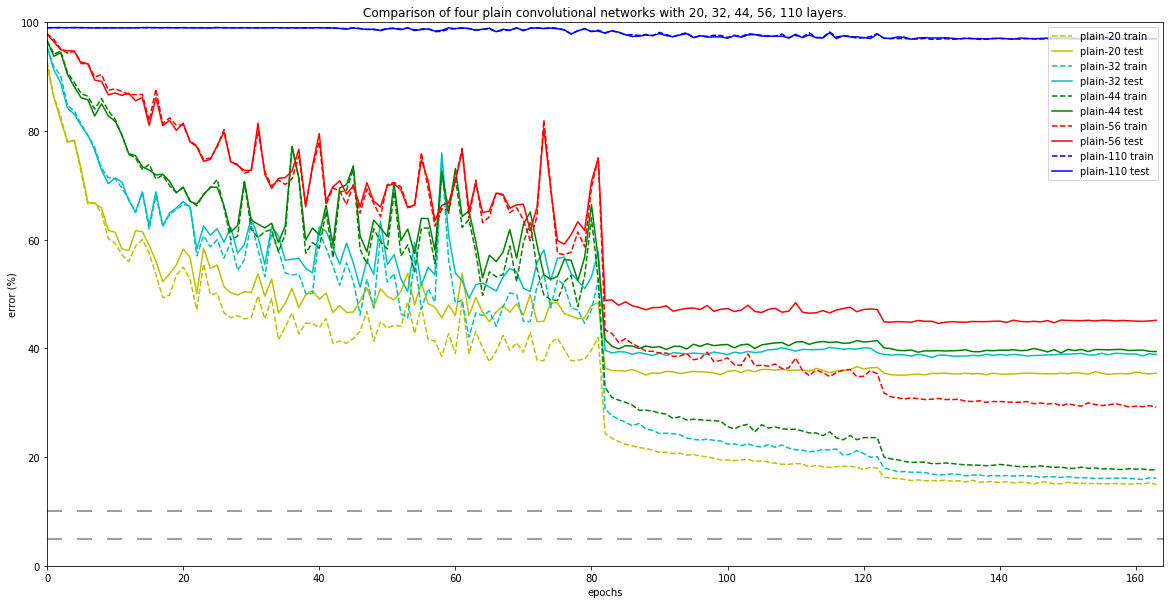

In [4]:
# ns  = [3, 5, 7, 9]
# clr = ['y', 'c', 'g', 'r']

ns = [3, 5, 7, 9, 18]
clr = ['y', 'c', 'g', 'r', 'b']

plainnet_dfs = [pd.read_csv(f'results/plainnet{6*n+2}_100.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 164, 0, 100])


for i in range(len(ns)):
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'plain-{6*ns[i]+2} train')
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'plain-{6*ns[i]+2} test')

plt.title('Comparison of four plain convolutional networks with 20, 32, 44, 56, 110 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [5]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in plainnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = ['PlainNet20', 'PlainNet32', 'PlainNet44', 'PlainNet56', 'PlainNet110']
display(bests_df[['model', 'test_err']])

,model,test_err
126,PlainNet20,0.3507
130,PlainNet32,0.3834
149,PlainNet44,0.3917
131,PlainNet56,0.4459
159,PlainNet110,0.9680


### Resnet

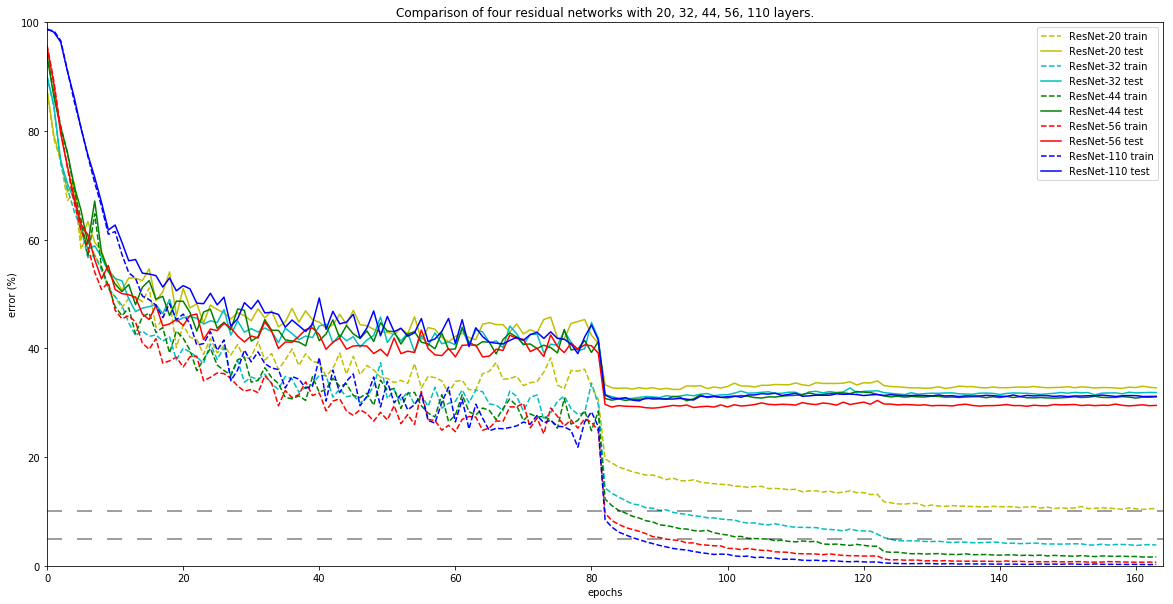

In [6]:
# ns  = [3, 5, 7, 9]
# clr = ['y', 'c', 'g', 'r']

ns = [3, 5, 7, 9, 18]
clr = ['y', 'c', 'g', 'r', 'b']

resnet_dfs = [pd.read_csv(f'results/resnet{6*n+2}_100.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 164, 0, 100])


for i in range(len(ns)):
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'ResNet-{6*ns[i]+2} train')
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'ResNet-{6*ns[i]+2} test')

plt.title('Comparison of four residual networks with 20, 32, 44, 56, 110 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [9]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in resnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = ['ResNet20', 'ResNet32', 'ResNet44', 'ResNet56', 'ResNet110']
display(bests_df[['model', 'test_err']])


,model,test_err
93,ResNet20,0.3244
85,ResNet32,0.3076
94,ResNet44,0.3035
89,ResNet56,0.2900
87,ResNet110,0.3034


## Side-by-side plot

In [ ]:
# ns  = [3, 5, 7, 9]
# clr = ['y', 'c', 'g', 'r']

ns = [3, 5, 7, 9, 18]
clr = ['y', 'c', 'g', 'r', 'b']

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 7))

plainnet_dfs = [pd.read_csv(f'results/plainnet{6*n+2}_100.csv') for n in ns]
resnet_dfs = [pd.read_csv(f'results/resnet{6*n+2}_100.csv') for n in ns]

def plot_results(dfs, ax, title):
    ax.axis([0, 164, 0, 100])
    
    for i in range(len(ns)):
        ax.plot(dfs[i]['epoch'], dfs[i]['train_err']*100, f'{clr[i]}--',
                 label=f'plain-{6*ns[i]+2} train')
        ax.plot(dfs[i]['epoch'], dfs[i]['test_err']*100, f'{clr[i]}',
                 label=f'plain-{6*ns[i]+2} test')
    
    ax.set_title(title)
    ax.legend(loc='bottom left')
    ax.set_xlabel('epochs')
    ax.set_ylabel('error (%)')
    ax.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
    ax.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));
    
plot_results(plainnet_dfs, ax1, 'Plain Networks')
plot_results(resnet_dfs, ax2, 'Residual Networks')